##### From [Recursion Cellular Image Classification - fastai starter]()

Welcome to the Recursion Cellular Image Classification Kaggle competition! Here, I provide a basic fastai starter code.

### Experiments
* [2019-09-17 10:17] Load stage-1, put do_flip=True, flip_vert=True into get_gransform() 

## Load modules

In [1]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import numpy as np
import pandas as pd
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

In [3]:
from pathlib import Path

DATA = Path("/mnt/disk4/cell/")

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 999
seed_everything(SEED)

Calcuate mean , std data on 6 channels

In [5]:
#lazy calculation of stats
pixel_stats = pd.read_csv(DATA/'pixel_stats.csv.zip')
channel1_mean = pixel_stats.iloc[::6,:]['mean'].mean()
channel2_mean = pixel_stats.iloc[1::6,:]['mean'].mean()
channel3_mean = pixel_stats.iloc[2::6,:]['mean'].mean()
channel4_mean = pixel_stats.iloc[3::6,:]['mean'].mean()
channel5_mean = pixel_stats.iloc[4::6,:]['mean'].mean()
channel6_mean = pixel_stats.iloc[5::6,:]['mean'].mean()


channel1_std = pixel_stats.iloc[::6,:]['std'].mean()
channel2_std = pixel_stats.iloc[1::6,:]['std'].mean()
channel3_std = pixel_stats.iloc[2::6,:]['std'].mean()
channel4_std = pixel_stats.iloc[3::6,:]['std'].mean()
channel5_std = pixel_stats.iloc[4::6,:]['std'].mean()
channel6_std = pixel_stats.iloc[5::6,:]['std'].mean()
stats = (torch.Tensor([channel1_mean,channel2_mean,channel3_mean,channel4_mean,channel5_mean,channel6_mean])/255,torch.Tensor([channel1_std,channel2_std,channel3_std,channel4_std,channel5_std,channel6_std])/255)
print(stats)

(tensor([0.0229, 0.0611, 0.0396, 0.0391, 0.0219, 0.0356]), tensor([0.0271, 0.0492, 0.0219, 0.0292, 0.0183, 0.0193]))


## Loading and formatting data

Here I will load the csv into the DataFrame, and create a column in the DataFrame with the path to the corresponding image (`generate_df`)

In [6]:
train_df = pd.read_csv(DATA/'train.csv')
train_df.head(10)

,id_code,experiment,plate,well,sirna
0,HEPG2-01_1_B03,HEPG2-01,1,B03,513
1,HEPG2-01_1_B04,HEPG2-01,1,B04,840
2,HEPG2-01_1_B05,HEPG2-01,1,B05,1020
3,HEPG2-01_1_B06,HEPG2-01,1,B06,254
4,HEPG2-01_1_B07,HEPG2-01,1,B07,144
5,HEPG2-01_1_B08,HEPG2-01,1,B08,503
6,HEPG2-01_1_B09,HEPG2-01,1,B09,188
7,HEPG2-01_1_B10,HEPG2-01,1,B10,700
8,HEPG2-01_1_B11,HEPG2-01,1,B11,1100
9,HEPG2-01_1_B12,HEPG2-01,1,B12,611


In [7]:
def generate_df(train_df,sample_num=1):
    train_df['path'] = train_df['experiment'].str.cat(train_df['plate'].astype(str).str.cat(train_df['well'],sep='/'),sep='/Plate') + '_s'+str(sample_num) + '_w'
    train_df = train_df.drop(columns=['id_code','experiment','plate','well']).reindex(columns=['path','sirna'])
    return train_df
proc_train_df = generate_df(train_df)  

In [8]:
proc_train_df.head(10)

,path,sirna
0,HEPG2-01/Plate1/B03_s1_w,513
1,HEPG2-01/Plate1/B04_s1_w,840
2,HEPG2-01/Plate1/B05_s1_w,1020
3,HEPG2-01/Plate1/B06_s1_w,254
4,HEPG2-01/Plate1/B07_s1_w,144
5,HEPG2-01/Plate1/B08_s1_w,503
6,HEPG2-01/Plate1/B09_s1_w,188
7,HEPG2-01/Plate1/B10_s1_w,700
8,HEPG2-01/Plate1/B11_s1_w,1100
9,HEPG2-01/Plate1/B12_s1_w,611


Let's look at an example image. These images are 6-channel images, but the each of the six channels are saved as separate files. Here, I open just one channel of the image.

In [9]:
import cv2
img = cv2.imread(str(DATA/"train/HEPG2-01/Plate1/B03_s1_w2.png"))
# plt.imshow(img)
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# plt.imshow(gray_img)
gray_img.shape

(512, 512)

In [10]:
img.shape

(512, 512, 3)

### New Class: MultiChannelImageList

In fastai, there is a modular data API that allows you to easily load images, add labels, split into train/valid, and add transforms. 

The base class for loading the images is an `ItemList`. For image classification tasks, the base class is `ImageList` which in turn subclasses the `ItemList` class. 

Since `ImageList` can only open 3-channel images, we will **define a new `ImageList` class** where we redefine the loading function:

In [11]:
def open_rcic_image(fn):
    images = []
    for i in range(6):
        file_name = fn+str(i+1)+'.png'
        im = cv2.imread(file_name)
        im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        images.append(im)
    image = np.dstack(images)
    #print(pil2tensor(image, np.float32).shape)#.div_(255).shape)
    return Image(pil2tensor(image, np.float32).div_(255))
  
class MultiChannelImageList(ImageList):
    def open(self, fn):
        return open_rcic_image(fn)

As I subclassed the ImageList function I can load images with the `ImageList` function `.from_df`. 

In [12]:
il = MultiChannelImageList.from_df(df=proc_train_df,path=DATA/'train')

We have to redefine the following function to be able to view the image in the notebook. I view just the first 3 channels.

In [13]:
def image2np(image:Tensor)->np.ndarray:
    "Convert from torch style `image` to numpy/matplotlib style."
    res = image.cpu().permute(1,2,0).numpy()
    if res.shape[2]==1:
        return res[...,0]  
    elif res.shape[2]>3:
        #print(res.shape)
        #print(res[...,:3].shape)
        return res[...,:3]
    else:
        return res

vision.image.image2np = image2np

Now let's view an example image:

In [14]:
# il[0]

With the multi-channel `ImageList` defined, we can now create a DataBunch of the train images. Let's first create a stratified split of dataset and get the indices. 

In [15]:
import sklearn
from sklearn.model_selection import StratifiedKFold
train_idx, val_idx = next(iter(StratifiedKFold(n_splits=int(1/0.035),random_state=5).split(proc_train_df, proc_train_df.sirna)))

Now we create the `DataBunch`

In [16]:
data = (MultiChannelImageList.from_df(df=proc_train_df,path=DATA/'train')
        .split_by_idx(val_idx)
        .label_from_df()
        .transform(get_transforms(do_flip=True, flip_vert = True),size=384)
        .databunch(bs=8,num_workers=0)
        .normalize(stats)
       )

In [17]:
# data.show_batch()

## Creating and Training a Model

[](http://)I will use a pretrained DenseNet. I have to now adjust the CNN arch to take in 6 channels as opposed to the usual 3 channels:

In [18]:
"""Inspired by https://github.com/wdhorton/protein-atlas-fastai/blob/master/resnet.py"""

import torchvision

RESNET_MODELS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

def resnet_multichannel(depth=50,pretrained=True,num_classes=1108,num_channels=6):
        model = RESNET_MODELS[depth](pretrained=pretrained)
        w = model.conv1.weight
        model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        model.conv1.weight = nn.Parameter(torch.stack([torch.mean(w, 1)]*num_channels, dim=1))
        return model

    
DENSENET_MODELS = {
    121: torchvision.models.densenet121,
    161: torchvision.models.densenet161,
    169: torchvision.models.densenet169,
    201: torchvision.models.densenet201,
}

def densenet_multichannel(depth=201,pretrained=True,num_classes=1108,num_channels=6):
        model = DENSENET_MODELS[depth](pretrained=pretrained)
        w = model.features.conv0.weight
        # switching the bottom layer
        model.features.conv0 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        # initialize the weight with original weights' mean across channels 
        model.features.conv0.weight = nn.Parameter(torch.stack([torch.mean(w, 1)]*num_channels, dim=1))
        return model
        

In [19]:
def _resnet_split(m): return (m[0][6],m[1])

def densenet201(pretrained,num_channels=6):
    return densenet_multichannel(depth=201,pretrained=pretrained,num_channels=num_channels)

def _densenet_split(m:nn.Module): return (m[0][0][7],m[1])

### Custom Head

In [20]:
class ArcMarginProduct(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features=5004): 
        super(ArcMarginProduct, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.reset_parameters()
        

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1)) # eq to input . This is more or less like Kaiming normal .
        #we use this to ensure values remain between 0 and 1 . Since std deviation reduces to almost half every layer
        # we can try some trick  multiplying it by 2 
        self.weight.data.uniform_(-stdv, stdv)
    
    def forward(self, features):
        cosine = F.linear(F.normalize(features), F.normalize(self.weight.cuda()))
        return cosine   

In [21]:
from torchvision import models as m

class Customhead(nn.Module):
    r"""Implement of large margin arc distance: :
        Args:
            in_features: size of each input sample
            out_features: size of each output sample
            s: norm of input feature
            m: margin
            cos(theta + m)
        """
    def __init__(self, in_features, out_features=1108):
        super(Customhead, self).__init__()
        body = create_body(m.densenet201, True, -1)
        nf = num_features_model(nn.Sequential(*body.children())) * 2
        self.head=create_head(nf, 1024,  ps=0.5, bn_final=False) # 1024 no of classes
        self.arc_margin=ArcMarginProduct(in_features,out_features)

    def forward(self, features):
        x=self.head(features)
        cosine = self.arc_margin(x)
        cosine = cosine.clamp(-1, 1)
        return cosine

In [22]:
class ArcFaceLoss(nn.modules.Module):
    def __init__(self,s=30.0,m=0.5):
        super(ArcFaceLoss, self).__init__()
        self.classify_loss = nn.CrossEntropyLoss()
        self.s = s
        self.easy_margin = False
        self.cos_m = math.cos(m) 
        self.sin_m = math.sin(m) 
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, inputs, labels, epoch=0,reduction=None):
        cosine = inputs
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, labels.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        loss1 = self.classify_loss(output, labels) # this is as per paper what is missing here is centralized features
        loss2 = self.classify_loss(cosine, labels)
        gamma=1
        loss=(loss1+gamma*loss2)/(1+gamma)
        return loss.mean()

In [23]:
ar=ArcFaceLoss().cuda()

Accuracy function from [here](https://www.kaggle.com/leighplt/densenet121-pytorch)

In [24]:
from fastai.metrics import accuracy

In [25]:
def acc_k(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return torch.Tensor(np.array(res))

In [26]:
custom_head=Customhead(1024,1108)

/opt/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Let's create our Learner:

In [27]:
learn = cnn_learner(data,densenet201,cut=-1,split_on=_densenet_split,lin_ftrs=[1024],metrics=[accuracy,acc_k], custom_head=custom_head, loss_func=ar)
#learn = cnn_learner(data,densenet201,cut=-1,split_on=_densenet_split,metrics=[accuracy])
learn.path = Path('../')

/opt/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


We can now find the appropriate learning rate and train the head of the model:

In [28]:
# learn.load("stage-1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.10E-07


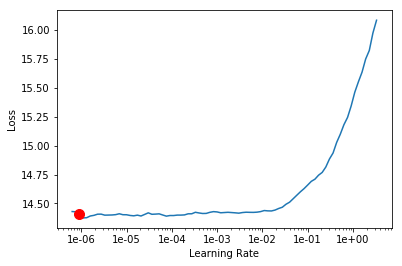

In [29]:
learn.lr_find() #<-- uncomment to determine the learning rate (commented to reduce time)
# learn.recorder.plot(suggestion=True)

In [30]:
learn.fit_one_cycle(4,1e-4)

epoch,train_loss,valid_loss,accuracy,acc_k,time
0,14.296886,14.339198,0.000451,0.045126,1:08:42
1,14.127627,14.178773,0.001805,0.180505,1:04:55


KeyboardInterrupt: 

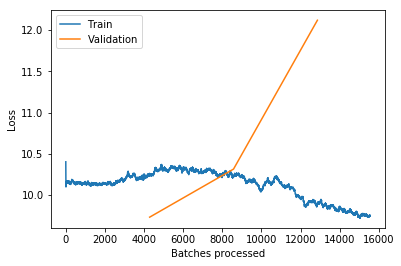

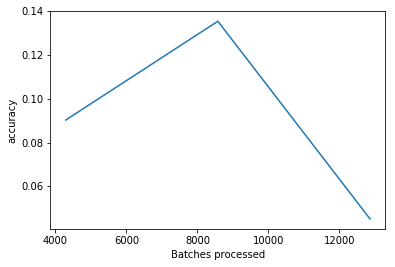

In [34]:
# learn.recorder.plot_losses()
# learn.recorder.plot_metrics()

In [31]:
learn.save('stage-2')
learn.export()

/opt/anaconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ArcFaceLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Customhead. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ArcMarginProduct. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


We will now unfreeze and train the entire model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


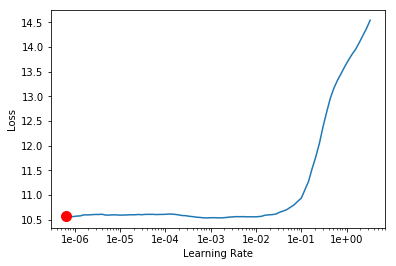

In [29]:
learn.unfreeze()
learn.lr_find() #<-- uncomment to determine the learning rate (commented to reduce time)
# learn.recorder.plot(suggestion=True) 

In [30]:
# learn.fit_one_cycle(2,slice(1e-6,5e-4))
#learn.fit_one_cycle(10,slice(1e-6,5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,10.373298,11.013427,0.180505,50:29
1,10.310205,11.354214,0.045126,50:34


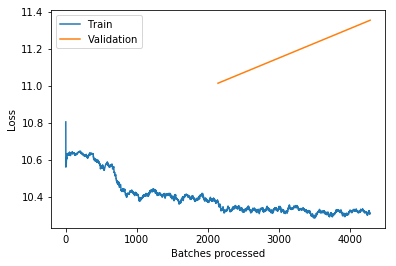

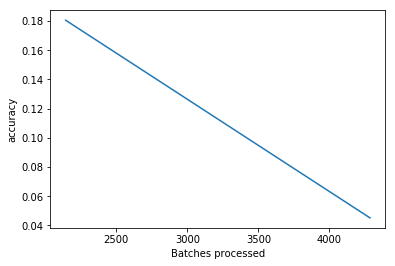

In [31]:
# learn.recorder.plot_losses()
# learn.recorder.plot_metrics()

In [32]:
learn.save('stage-1')
#learn.export()

## Inference and Submission Generation

Let's now load our test csv and process the DataFrame like we did for the training data.

In [33]:
test_df = pd.read_csv(DATA/'test.csv')
proc_test_df = generate_df(test_df.copy())

We add the data to our DataBunch:

In [42]:
data_test = MultiChannelImageList.from_df(df=proc_test_df,path=DATA/'test')
learn.data.add_test(data_test)

NameError: name 'proc_test_df' is not defined

Now we can get out predictions on the test set.

In [ ]:
preds, _ = learn.get_preds(DatasetType.Test)

In [ ]:
preds_ = preds.argmax(dim=-1)

In [ ]:
test_df.head(10)

Let's open the sample submission file and load it with our predictions to create a submission.

In [ ]:
submission_df = pd.read_csv(DATA/'sample_submission.csv')

In [ ]:
submission_df.sirna = preds_.numpy().astype(int)
submission_df.head(10)

In [ ]:
submission_df.to_csv(DATA/'submission.csv',index=False)

That's it!

## Future work:

This is only a simple baseline. There are many different things we can change:
* Use both sites (right now I only use site 1)
* Model architecture
* Train multiple classifiers for different cell types
* **Metric learning** - This will be the key to successful submissions